In [48]:
# pip install networkx
# pip install matplotlib
# pip install tqdm
# pip install pandas
# pip install numpy
# pip install graphviz
# pip install scikit-learn

In [3]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt

# Task 1. Algorithm's analysis

## Generating graph

In [4]:

# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

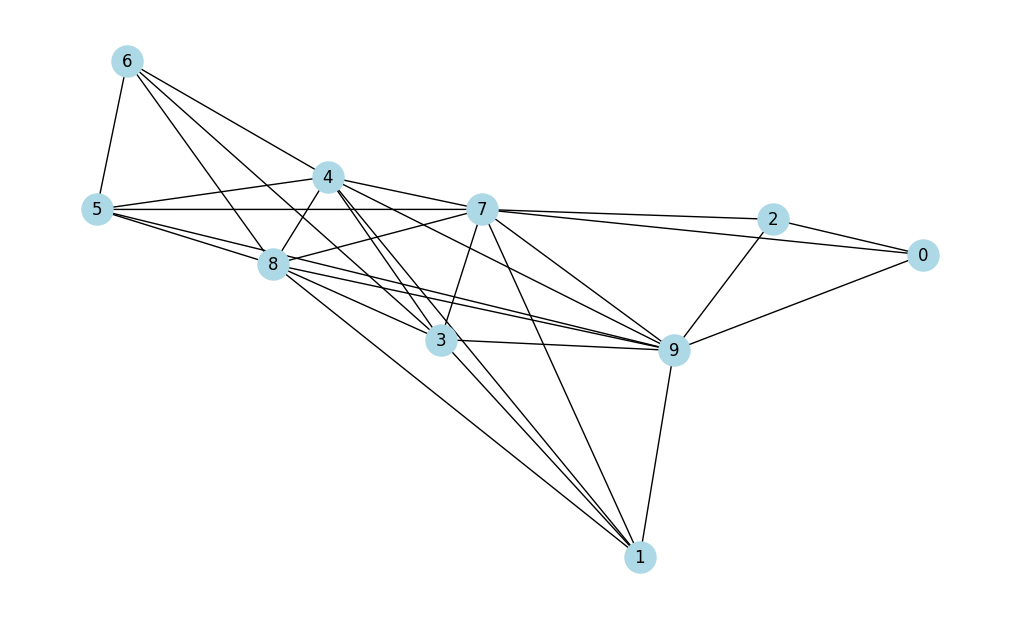

In [6]:
G = gnp_random_connected_graph(10, 0.5, False, True)

## Subtask 1.1

### Prim's algorithm

In [7]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

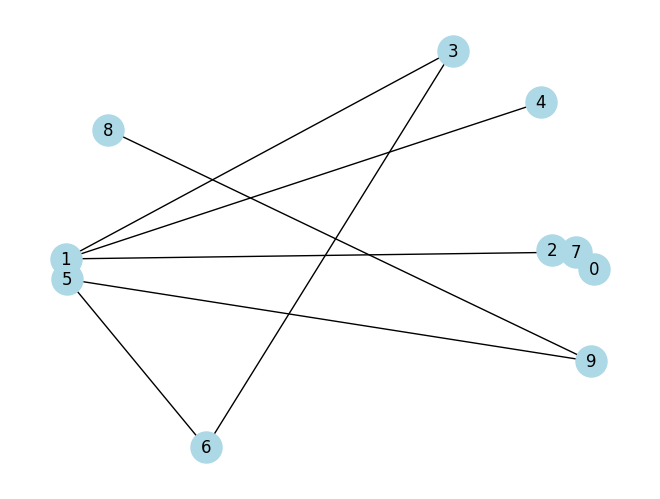

In [8]:
nx.draw(mstp, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [9]:
mstp.edges(), len(mstp.edges())

(EdgeView([(0, 7), (1, 7), (1, 3), (1, 4), (2, 7), (3, 6), (5, 6), (5, 9), (8, 9)]),
 9)

**Код Прима написаний нами:**

In [10]:

def prim_algorithm(G: nx.Graph):
    """Prim's algorithm"""
    my_mst = nx.Graph()


    edges = list(G.edges(data=True))
    list_of_edges = []
    for p1, p2, weig in edges:
        list_of_edges.append((p1, p2, weig['weight']))

    nodes = list(G.nodes())

    result_edges = []
    u = [nodes[0]]

    while len(u) < len(nodes):
        list_of_possible_next_edges = []

        for edg in list_of_edges:
            if (edg[0] in u and edg[1] not in u) or (edg[1] in u and edg[0] not in u):
                list_of_possible_next_edges.append(edg)

        if list_of_possible_next_edges:
            next_edge = min(list_of_possible_next_edges, key=lambda x: x[2])
            result_edges.append(next_edge)
            
            if next_edge[0] in u:
                u.append(next_edge[1])
            else:
                u.append(next_edge[0])
            
            list_of_edges.remove(next_edge)

    result_edges = sorted(result_edges, key = lambda x: x[0])
    for edge in result_edges:
        my_mst.add_edge(edge[0], edge[1], weight = edge[2])

    print("№  Ребра  Вага")
    for i, edge in enumerate(result_edges):
        print(f"{i+1}) {edge[0]} -- {edge[1]} : {edge[2]}")
    total_weight = sum(ed[2] for ed in result_edges)
    print(f'загальна вага mst: {total_weight}')
    return my_mst

№  Ребра  Вага
1) 0 -- 7 : 2
2) 1 -- 7 : -4
3) 1 -- 3 : -1
4) 1 -- 4 : 0
5) 2 -- 7 : 7
6) 3 -- 6 : -1
7) 5 -- 6 : 1
8) 5 -- 9 : -1
9) 8 -- 9 : -5
загальна вага mst: -2


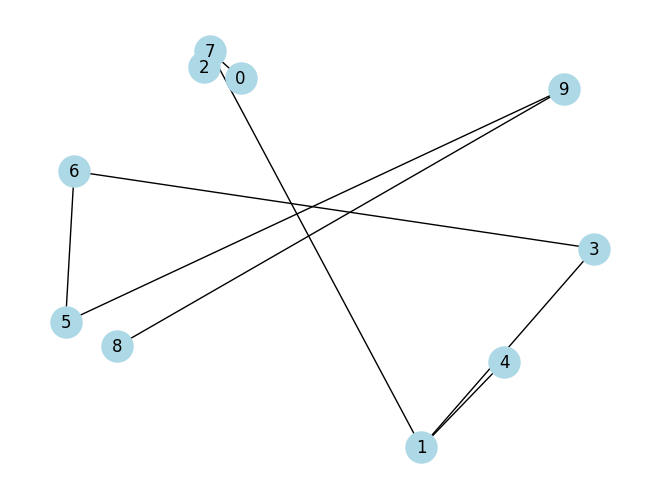

In [11]:
prim_alg = prim_algorithm(G)
nx.draw(prim_alg, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

## Subtask 1.2

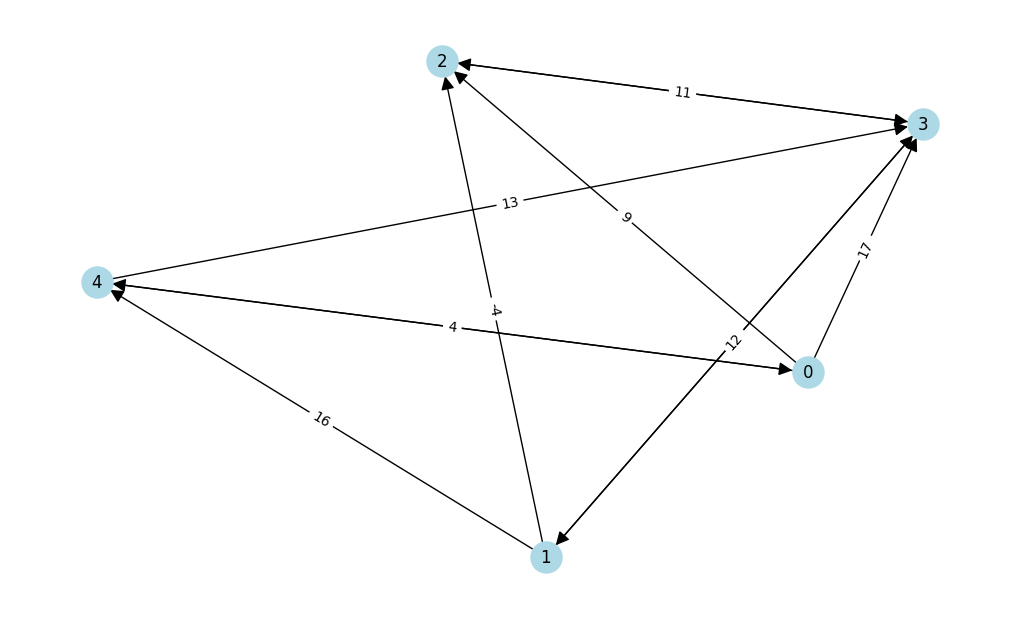

In [12]:
G = gnp_random_connected_graph(5, 0.8, True, True)

### Bellman-Ford algorithm

In [13]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Distance to 0: 0
Distance to 2: 9
Distance to 3: 9
Distance to 4: 3
Distance to 1: 21


**Алгоритм Белмана-Форда реалізований нами:**

In [14]:
def bellman_ford(vertices, edges):
    dist = {v: float('inf') for v in vertices}
    dist[0] = 0

    for _ in range(len(vertices) - 1):
        for u, v, weight in edges:
            if dist[u] != float('inf') and dist[u] + weight < dist[v]:
                dist[v] = dist[u] + weight
    
    for u, v, weight in edges:
        if dist[u] != float('inf') and dist[u] + weight < dist[v]:
            print("Kaput! there is negative cycle ")
            return None
    
    return dist

In [15]:
edges = list(G.edges(data=True))
list_of_edges = []
for p1, p2, weig in edges:
    list_of_edges.append((p1, p2, weig['weight']))
nodes = list(G.nodes())

try:
    dist = bellman_ford(nodes, list_of_edges)
    
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Distance to 0: 0
Distance to 1: 21
Distance to 2: 9
Distance to 3: 9
Distance to 4: 3


---

## Some useful explanations
### How to get list of edges for your algorithm

In [14]:
edges = list(G.edges()) # by default G.edges are EdgesView class

In [15]:
edges[:5]

[(0, 1), (0, 9), (1, 6), (1, 7), (1, 8)]

### To get edges with weights

In [16]:
edges = list(G.edges(data=True))

In [17]:
edges[:5]

[(0, 1, {'weight': 8}),
 (0, 9, {'weight': 6}),
 (1, 6, {'weight': 3}),
 (1, 7, {'weight': 8}),
 (1, 8, {'weight': 8})]

In [18]:
nodes = list(G.nodes())
print(nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## Example on time measuring

Read more on this: https://realpython.com/python-timer/

Recall that you should measure times for 5, 10, 20, 50, 100, 200, 500 nodes 1000 times (and take mean of time taken for each node amount).

Then you should build the plot for two algorithms (x - data size, y - mean time of execution).

In [22]:
import time
from tqdm import tqdm

In [23]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(100, 0.4, False)
    
    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:02<00:00, 336.14it/s]


0.0008106007575988769

## Task 2. Decision Tree Classifier 

In [21]:
# scikit-learn package
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### General idea

#### You are expected to write a quite simple, yet good core logic of decision tree classifier class. Additionaly, you need to test your results and write down a report on what you've done, which principles used and explain the general process.

#### Hopefully, you have already learned what is decision tree classifier and how it work. For better understanding, and in case if something is still unclear for you, here are some useful links on basics of DTC:
- https://www.youtube.com/watch?v=ZVR2Way4nwQ
- https://towardsdatascience.com/decision-tree-classifier-explained-a-visual-guide-with-code-examples-for-beginners-7c863f06a71e
- https://towardsdatascience.com/decision-tree-from-scratch-in-python-46e99dfea775
- https://www.kaggle.com/code/prashant111/decision-tree-classifier-tutorial
- https://towardsdatascience.com/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b6057

#### Also, for those interested to learn more about machine learning and particulary Desicion Trees - here is a great course on Coursera (you may be interested in the whole course or just this particular week):
- https://www.coursera.org/learn/advanced-learning-algorithms/home/week/4


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)


### Dataset
#### You can use Iris dataset for this task. It is a very popular dataset for machine learning and data science. It contains 150 samples of 3 different species of Iris flowers (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. 
Read more on this: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
https://en.wikipedia.org/wiki/Iris_flower_data_set
#### However, using more interesting and intricate datasets is much appreciated. You can use any dataset you want, but it should be a classification one. For example you can use breast cancer or wine datasets, which are also available in sklearn.datasets. Or you can use any other dataset you find interesting.
P.S. In case you are not sure if your dataset is suitable, feel free to ask assistants :).

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [22]:
# Load dataset
iris = load_iris()
dir(iris)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [23]:
iris.data.shape

(150, 4)

This means that we have 150 entries (samples, infos about a flower). The columns being: Sepal Length, Sepal Width, Petal Length and Petal Width(features). Let's look at first two entries:

In [24]:
iris.data[0:2]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2]])

### To undestand data little bit better, let's plot some features

Text(0, 0.5, 'Sepal width')

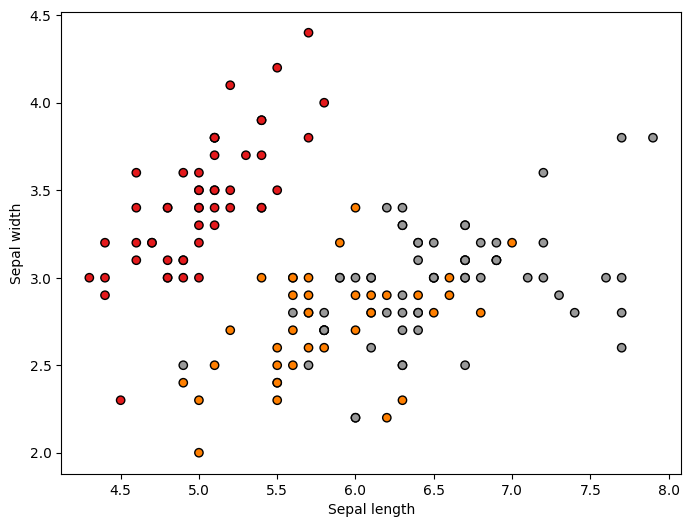

In [25]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

From this we can clearly see, that even basing on those two parameters, we can clearly divide (classify) out data into several groups. For this, we will use decision tree classifier: https://scikit-learn.org/stable/modules/tree.html#tree

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Example of usage


**Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression**. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

In [26]:
clf = DecisionTreeClassifier()

X, y = iris.data, iris.target
X.shape, y.shape

((150, 4), (150,))

### Train / test split

We train our model using training dataset and evaluate its performance basing on the test dataset. Reason to use two separate datasets is that our model learns its parameters from data, thus test set allows us to check its possibilities on completely new data.

In [27]:
X, X_test, y, y_test = train_test_split(X, y, test_size= 0.20)
X_test.shape, y_test.shape

((30, 4), (30,))

### Model learning

It learns its parameters (where it should split data and for what threshold value) basing on the training dataset. It is done by minimizing some cost function (e.g. Gini impurity or entropy).

In [28]:
clf = clf.fit(X, y)

### Visualization of produced tree

You do not need to understand this piece of code :)

In [29]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris")

'iris.pdf'

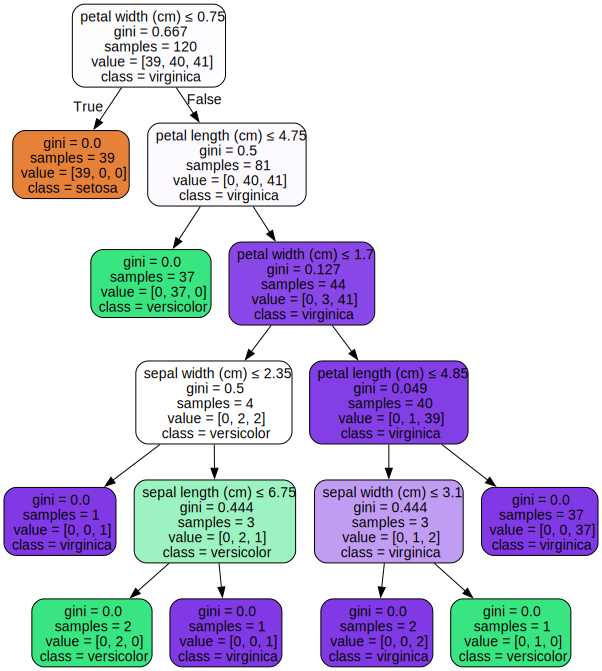

In [30]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=iris.feature_names,  
                     class_names=iris.target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### Prediction step

Now we can use our model to predict which type has a flower, basing on its parameters.

This is conducted basically via traversing the tree that you can see above.

In [31]:
predictions = clf.predict(X_test)

### We can also measure the accuracy of our model

In [32]:
sum(predictions == y_test) / len(y_test)

np.float64(0.8)

To get clearer intuition about predicion, let's look at those X, that should be labeled to some flower

In [33]:
y_test

array([2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 1, 2, 1, 1, 1, 0, 2, 1, 0, 1, 0, 0,
       1, 2, 1, 0, 1, 1, 0, 2])


Here you can traverse the tree above by yourself and make sure that prediction works

In [34]:
X_test[1]

array([4.9, 3.1, 1.5, 0.2])

In [35]:
clf.predict([X_test[1]])

array([0])

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Finally, it is your turn to write such classifier by yourself!

####  Gini impurity

Decision trees use the concept of Gini impurity to describe how “pure” a node is. A node is pure (G = 0) if all its samples belong to the same class, while a node with many samples from many different classes will have a Gini closer to 1.

$G = 1 - \sum_{k=1}^{n}p_{k}^2$

For example, if a node contains five samples, with two belonging to the first class (first flower), two of class 2, one of class 3 and none of class 4, then

$G = 1 - (\frac{2}{5})^2 - (\frac{2}{5})^2 - (\frac{1}{5})^2 = 0.64$

#### Remarks 
- We recommend using additional functions in `DecisionTreeClassifier` class, to make the implementation process easier.
- [use this hint](https://arc.net/l/quote/pqvyjqei)

In [36]:

class Node:
    def __init__(self, X: npt.NDArray, y: npt.NDArray):
        """
        :param X: numpy array of form [[feature1,feature2, ... featureN], ...] (i.e. [[1.5, 5.4, 3.2, 9.8] , ...] for case with iris d.s.)
        :param y: numpy array of from [class1, class2, ...] (i.e. [0,1,1,2,1,0,...] for case with iris d.s.)
        """

        self.X = X
        self.y = y
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

In [37]:
class DecisionTreeClassifier:
    def __init__(self, max_depth: int) -> None:
        self.max_depth = max_depth
        self.tree = None
        self.number_of_classes = None
        
        
    def fit(self, X: npt.NDArray, y: npt.NDArray) -> None:
        """
        Basically, function that performs all the training (building of a tree)
        We recommend to use it as a wrapper of recursive building function
        """
        self.number_of_classes = np.unique(y).size


    
    def predict(self, X_test: npt.NDArray) -> list:
        """
        Traverse the tree while there is a child
        and return the predicted class for it 
        """
        pass

In [38]:

def evaluate(X_test: list[list], y_test: list) -> float:
    """
    Returns accuracy of the model (ratio of right guesses to the number of samples)
    """
    pass

***put your code below, with usage and evaluation of Decision classifier tree*** (delete this)